In [43]:
import os
import redis
import hashlib
from metaflow import FlowSpec, step, S3
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle

# Ejemplo de predicción de modelo usando Redis

Este notebook muestra cómo obtener predicciones de un modelo que produce predicciones en lotes. Las predicciones se cargaron en Redis. 

En este notebook, recuperamos las predicciones del modelo almacenadas en Redis. Los datos deben ser leídos, convertidos a cadenas y luego hasheados. Con este enfoque, podemos verificar si los datos existen en Redis y recuperar la predicción correspondiente. En caso de que los datos no existan, asignamos un valor de cero. Esta estrategia simula cómo podría comportarse un servicio en producción ante casos no contemplados.

La ventaja de utilizar Redis en este contexto radica en su capacidad para almacenar datos de forma eficiente en memoria, lo que permite un acceso rápido a las predicciones previamente calculadas. Además, Redis ofrece funcionalidades de almacenamiento en caché y persistencia de datos, lo que garantiza la disponibilidad y la integridad de las predicciones incluso en entornos de producción de alta demanda.

In [44]:
# Conectamos al servidor redis (asegúrate de que el docker compose esté corriendo)
r = redis.Redis(host='localhost', port=6379, decode_responses=True)

# Configuración de las credenciales de acceso a AWS S3 (minio)
os.environ['AWS_ACCESS_KEY_ID'] = "minio"
os.environ['AWS_SECRET_ACCESS_KEY'] = "minio123"
os.environ['AWS_ENDPOINT_URL_S3'] = "http://localhost:9000"

In [45]:
# Obtención de datos para prueba

df = pd.read_csv("./breast_cancer.csv", header=None)

# Sampleamos 100 valores al azar
df_temp = df.sample(50)

test_values = df_temp.values.tolist()

s3 = S3(s3root="s3://amqtp/")
scaler_obj = s3.get("scaler.pkl")
with open(scaler_obj.path, 'rb') as f:
    scaler = pickle.load(f)

# Aplicamos el scaler a los datos
scaled_values = scaler.transform(df_temp)

print(scaled_values)

# Conversión de valores a cadenas y hash
# Esto debería implementarse en el pipeline. Dado que los números de punto flotante pueden 
# presentar problemas debido a pequeñas variaciones, se podría considerar redondearlos.
string_values = [' '.join(map(str, sublist)) for sublist in scaled_values]
hashed_values = [hashlib.sha256(substring.encode()).hexdigest() for substring in string_values]

# Inicializamos un diccionario para almacenar las salidas del modelo
model_outputs = {}

# Obtenemos las predicciones almacenadas en Redis
for hash_key in hashed_values:
    model_outputs[hash_key] = r.hgetall(f"predictions:{hash_key}")

# Reemplazo de valores nulos con un valor predeterminado
# Esto es necesario porque, en caso de una nueva entrada que el modelo no haya visto durante 
# el procesamiento por lotes, necesitamos proporcionar una salida. Esta entrada podría ser
# encolada para su posterior procesamiento en lotes.
# model_output = [value if value is not None else "jjjj" for value in model_output]

[[-0.14048084 -0.67220742 -0.18534699 ... -0.42000973 -0.12371107
  -0.32678664]
 [ 0.2559754   1.56359668  0.23676448 ...  0.60749209 -0.36792791
   0.6197232 ]
 [-0.19711744  0.3946109  -0.15896502 ...  1.75473329 -0.12210438
   1.3467525 ]
 ...
 [ 0.30978017 -1.48479509  0.24377219 ... -0.16203719 -0.90456229
  -0.50282833]
 [ 1.47932605  1.03137552  1.51876316 ...  0.66704833  0.05945156
  -0.42280938]
 [-0.51994609  0.72724913 -0.5114116  ... -0.49994047 -0.98811015
   0.41624645]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Veamos la salida del modelo para diferentes entradas:

In [46]:
print("Salidas de los modelos para las primeras 5 entradas:")
for index, test_value in enumerate(test_values):
    hash_key = hashed_values[index]
    tree_prediction = model_outputs[hash_key].get('tree', 'No disponible')
    svc_prediction = model_outputs[hash_key].get('svc', 'No disponible')
    knn_prediction = model_outputs[hash_key].get('knn', 'No disponible')
    reglog_prediction = model_outputs[hash_key].get('reglog', 'No disponible')
    
    print(f"\nPara la entrada: {test_value}")
    print(f"El modelo tree predice: {tree_prediction}")
    print(f"El modelo svc predice: {svc_prediction}")
    print(f"El modelo knn predice: {knn_prediction}")
    print(f"El modelo reglog predice: {reglog_prediction}")

print("\nSe han mostrado las predicciones para las primeras 5 entradas.")

Salidas de los modelos para las primeras 5 entradas:

Para la entrada: ['13.68', '16.33', '87.76', '575.5', '0.09277', '0.07255', '0.01752', '0.0188', '0.1631', '0.06155', '0.2047', '0.4801', '1.373', '17.25', '0.003828', '0.007228', '0.007078', '0.005077', '0.01054', '0.001697', '15.85', '20.2', '101.6', '773.4', '0.1264', '0.1564', '0.1206', '0.08704', '0.2806', '0.07782']
El modelo tree predice: Benigno
El modelo svc predice: Benigno
El modelo knn predice: Benigno
El modelo reglog predice: Benigno

Para la entrada: ['15.08', '25.74', '98.0', '716.6', '0.1024', '0.09769', '0.1235', '0.06553', '0.1647', '0.06464', '0.6534', '1.506', '4.174', '63.37', '0.01052', '0.02431', '0.04912', '0.01746', '0.0212', '0.004867', '18.51', '33.22', '121.2', '1050.0', '0.166', '0.2356', '0.4029', '0.1526', '0.2654', '0.09438']
El modelo tree predice: Maligno
El modelo svc predice: Maligno
El modelo knn predice: Maligno
El modelo reglog predice: Maligno

Para la entrada: ['13.48', '20.82', '88.4', '559

# Representemos graficamente a estos datos
test_values_df = pd.DataFrame(test_values)
test_values_df = pd.concat([test_values_df, pd.Series(model_output)], axis=1)
test_values_df.columns=["0", "1", "2", "3", "label"]
sns.scatterplot(x="2", y="3", hue="label", data=test_values_df)
plt.title("Model output for test values");

/var/folders/97/rjv58j2d05ncbzgd707sdn600000gn/T/ipykernel_79756/2479480216.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="0", y="1", hue=model, data=test_values_df, palette="viridis")
/var/folders/97/rjv58j2d05ncbzgd707sdn600000gn/T/ipykernel_79756/2479480216.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="0", y="1", hue=model, data=test_values_df, palette="viridis")
/var/folders/97/rjv58j2d05ncbzgd707sdn600000gn/T/ipykernel_79756/2479480216.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="0", y="1", hue=model, data=test_values_df, palette="viridis")
/var/folders/97/rjv58j2d05ncbzgd707sdn600000gn/T/ipykernel_79756/2479480216.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="0", y="1", hue=model, data=test_values_df, palette="viridis")


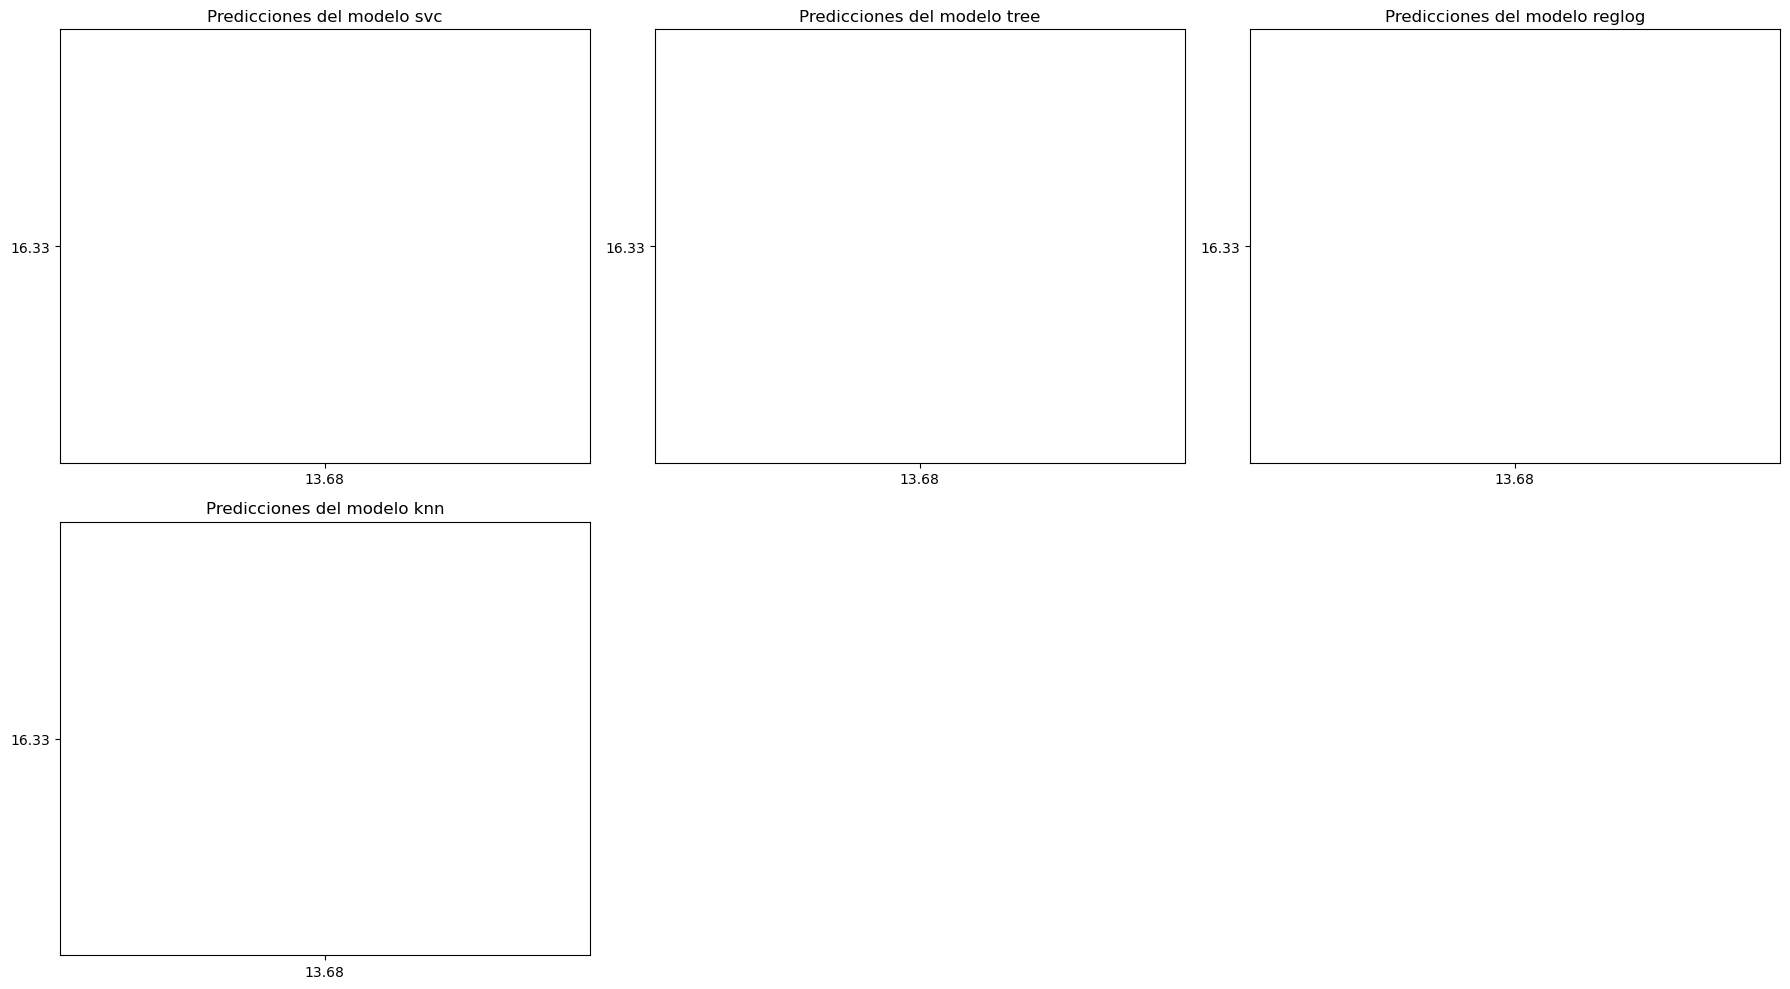

In [47]:

# Creamos un DataFrame con los valores de test
test_values_df = pd.DataFrame(test_values)

# Obtenemos la lista de modelos disponibles
models = list(set().union(*[set(output.keys()) for output in model_outputs.values()]))

# Agregamos las predicciones de cada modelo al DataFrame
for model in models:
    test_values_df[model] = [model_outputs[hash_key].get(model, 'No disponible') for hash_key in hashed_values]

# Renombramos las columnas
test_values_df.columns = [str(i) for i in range(len(test_values_df.columns) - len(models))] + models

# Convertimos las predicciones a valores numéricos
for model in models:
    test_values_df[model] = pd.to_numeric(test_values_df[model], errors='coerce')

# Creamos los scatter plots
n_cols = 3  # Número de columnas en la cuadrícula de gráficos
n_rows = (len(models) + n_cols - 1) // n_cols  # Número de filas necesarias

plt.figure(figsize=(6*n_cols, 5*n_rows))

for i, model in enumerate(models, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x="0", y="1", hue=model, data=test_values_df, palette="viridis")
    plt.title(f"Predicciones del modelo {model}")

plt.tight_layout()
plt.show()